In [1]:
%load_ext autoreload
%autoreload 2

# Pilot CFM implementation

Implementation consists of two stages:

0. (generate data)
1. Model the relative input range of the callee function regarding the input of the caller function
2. Model the branch condition regarding the input of each function

## Stage 0. Generate data

### Load example programs


In [2]:
from example.python.crash import crashme_tup, crashme3_tup
from example.python.triangle import triangle_tup, triangle3_tup
from example.python.count import count_tup

import inspect

### Fuzzing configuration


In [3]:
program, seed_input_list = crashme3_tup
# program, seed_input_list = triangle3_tup
print(inspect.getsource(program))
try:
    program(seed_input_list[1])
except Exception as e:
    print(e)

n = 10000

def crashme3(s):
    if len(s) != 15:
        raise Exception("Wrong input.")
    if s[0] == "1":
        crashme(s[3:7])
    elif s[1] == "1":
        crashme(s[7:11])
    elif s[2] == "1":
        crashme(s[11:15])
    else:
        raise Exception("Wrong input.")

Deep bug!


### Run fuzzer and record input, and the execution trace


In [4]:
from GreyboxFuzzer import GreyboxFuzzerRecorder
from MutationFuzzer import Mutator, PowerSchedule
from Coverage import FunctionContCovRunner

greybox_recorder = GreyboxFuzzerRecorder(
    seed_input_list, Mutator(), PowerSchedule()
)
runner = FunctionContCovRunner(program)
greybox_recorder.runs(runner, trials=n)
record = greybox_recorder.get_record()

print(f"Unique path: {len(record)}\n")
for path, inputs in list(record.items())[:3]:
    print(f"{path=}")
    print(f"{inputs=}")
    print()

Unique path: 17

path=(('', ('crashme3', 10)), ('', ('crashme3', 12)), ('', ('crashme3', 14)), ('', ('crashme3', 16)), ('', ('crashme3', 19)), ('', ('__exit__', 83)))
inputs={'gz4asdbQd7b\x01mD!', '000ab$cdefghijl', 'v5as%v`fbad7Qdr', 'G000#abcdefghC4', '$!0a5bkdeffghld', 'Q0a?f@bk`!UwdS2', '00asdfioB7ye2bd', '000abcdefghijkl', '20p12fq7Rjdgkex', '002vqb#vdefHi;L'}

path=(('', ('crashme3', 10)), ('', ('crashme3', 12)), ('', ('crashme3', 13)), ('crashme3:13', ('crashme', 2)), ('crashme3:13', ('crashme', 3)), ('crashme3:13', ('crashme', 4)), ('crashme3:13', ('crashme', 5)), ('crashme3:13', ('crashme', 6)), ('', ('__exit__', 83)))
inputs={'100bad!asdfqwer', '100bad!asdCfqer', '100bad!asdfRmqr', '100bad!i+s&df\x7fW', '10Xbad!sdfq<ser', '10pbad!adfqverl', '100bad!adfqwer|', '100bad!asd&Qwer', '100bad!asdfawEr', '1&0bad!asdfqwer'}

path=(('', ('crashme3', 10)), ('', ('crashme3', 12)), ('', ('crashme3', 14)), ('', ('crashme3', 15)), ('crashme3:15', ('crashme', 2)), ('crashme3:15', ('crashme',

### Create a control-flow graph from execution traces

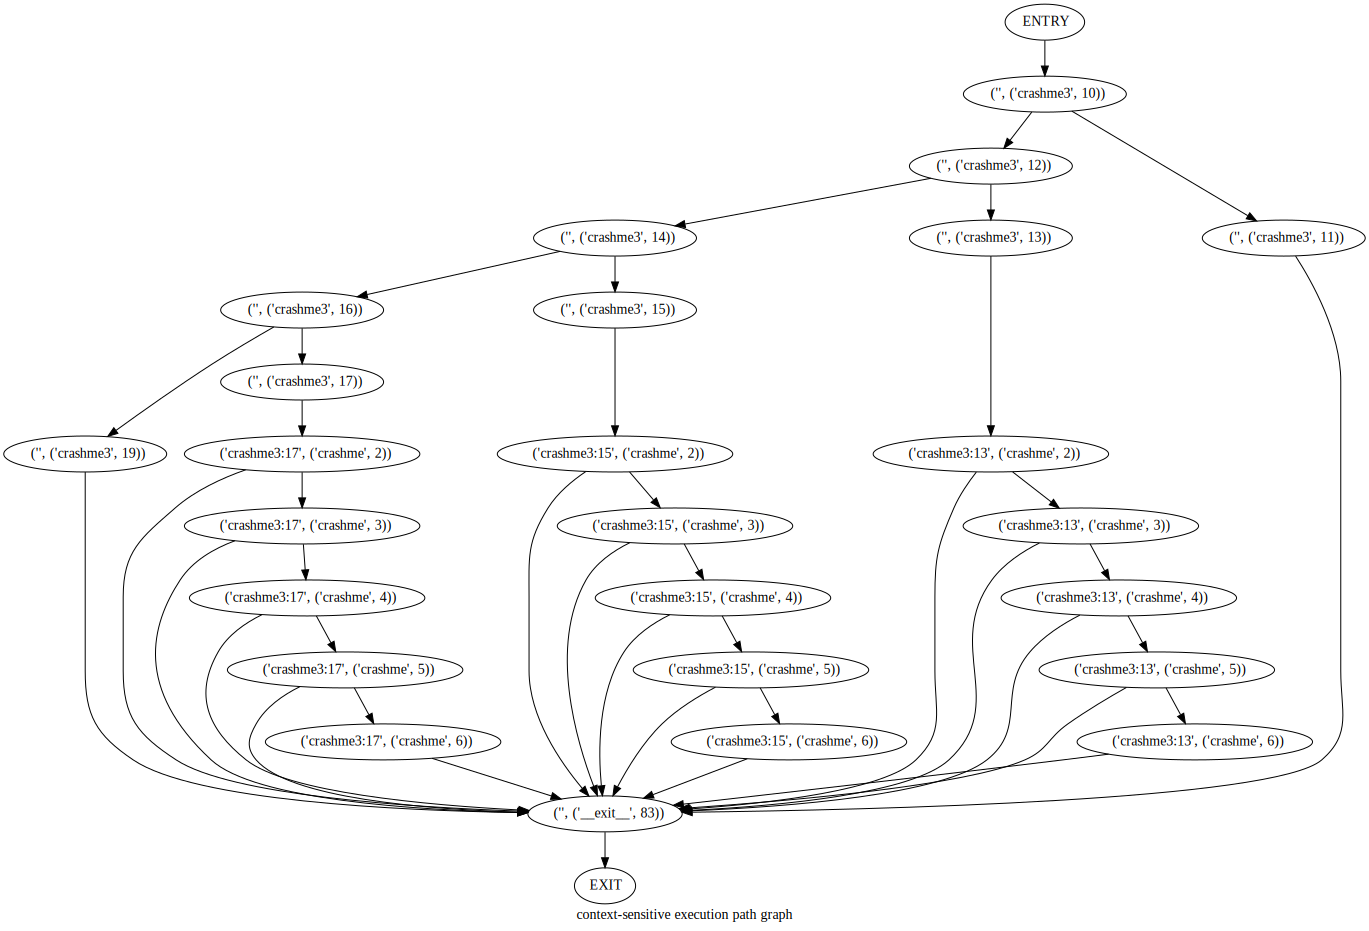

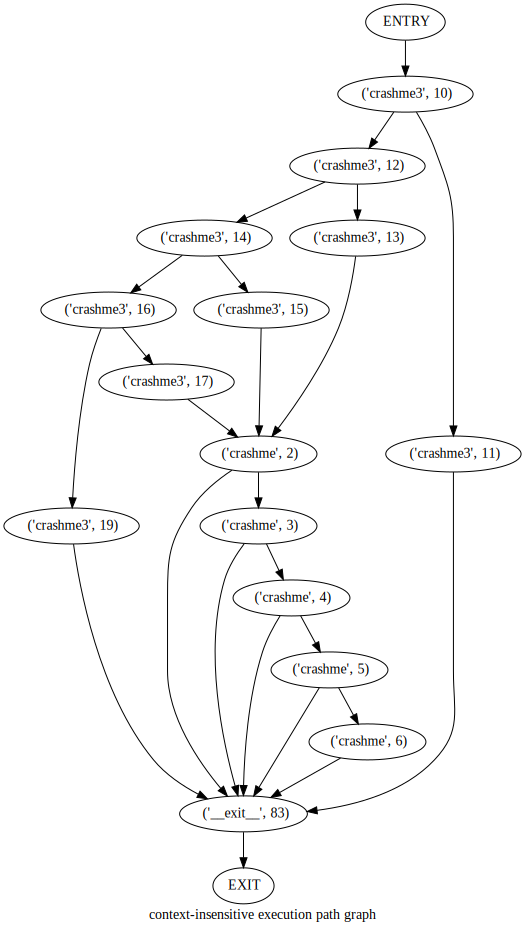

In [5]:
from graph import Graph

contcov_graph = Graph()
coverage_graph = Graph()
for path, inputs in record.items():
    contcov_graph.accept(path)
    coverage_list = [contcov[1] for contcov in path]
    coverage_graph.accept(coverage_list)
display(contcov_graph.print_graph("context-sensitive execution path graph"))
display(coverage_graph.print_graph("context-insensitive execution path graph"))


# Stage 1. Model the relative input range of the callee function regarding the input of the caller function

### Identify the branch can the call position from the control-flow graph

In [6]:
from ControlFlowModel import ControlFlowModel

CFM = ControlFlowModel(record, contcov_graph, coverage_graph, runner)
CFM.identify_branch()
CFM.identify_call_context()

branches: [<('crashme3', 10)>, <('crashme3', 12)>, <('crashme3', 14)>, <('crashme3', 16)>, <('crashme', 2)>, <('crashme', 3)>, <('crashme', 4)>, <('crashme', 5)>]
call contexts: {'crashme3:17', 'crashme3:15', 'crashme3:13'}


### Compute the relative input range of the callee function regarding the input of the caller function using the linear programming

Key idea is as follows:

Let's say the absolute input byte array used in the caller function g is [a, b). 

If the callee function f uses the input range of [fmin, fmax) relative to the input of the caller function g,
then the absolute input byte array range of f, called from g, is [a + fmin, a + fmax). 

Let's say 
- (f1, f2, ..., fn) is the call sequence of the execution to reach the function f, and
- i1, ..., im are the absolute indices of the input byte array that affects the control flow of a function f

Then, following three inequalities are satisfied:
- f1min + f2min + ... + f(n-1)min + fnmin <= imin
- f1min + f2min + ... + f(n-1)min + fnmax >= imax
- f1max - f1min >= imax - imin

where, fimin, fimax are the relative input range used for the function fi regarding its caller's input byte array, and imin, imax are the max(i1, ..., im) and min(i1, ..., im) respectively.

If we have bunch of the pair of ((f1, f2, ..., fn), (i1, ..., im)), we can write the above inequalities as a linear programming problem, where the global minimum of the objective function is sum_i(fimax - fimin). Below is the example of the modeling.

```
[Program's relative input range on use]
input: [0, 10)
func a: [5, 10)
func b: [1, 3)
func c: [1, 2)

[Data]
(a, b, c) -> {7},
   (a, c) -> {6},
   (b, c) -> {2},
      (c) -> {1}
=>
func a: [5, 7)
func b: [1, 3)
func c: [1, 2)
```
 <!-- [Temp] assign temporary contextmap -- need to be changed to learn this -->

In [7]:
CFM.model_context(mut_trial=100)

/Users/bohrok/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/bohrok/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/b0005975fc5c4e868593b226640a1b3a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/b0005975fc5c4e868593b226640a1b3a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 17 COLUMNS
At line 42 RHS
At line 55 BOUNDS
At line 62 ENDATA
Problem MODEL has 12 rows, 6 columns and 18 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-12) rows, 0 (-6) columns and 0 (-18) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 12
After Postsolve, objective 12, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 12 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed

# Stage 2. Model the branch condition regarding the input of each function

For each branch condition and a set of input used in the current function, a fixed number of random predicate is generated for the true condition and the false condition. The fitness of the predicate is evaluated by the number of inputs that the result of the predicate and actual execution match. The predicate with the highest fitness is selected as the predicate for the branch condition.

In [8]:
CFM.model_condition(max_trial=1000)

Modeling <('crashme3', 10)> -> <('crashme3', 12)>... formula: <lambda x: x[3] != x[14]> (conf: 0.9529411764705882, trial: (1000 / 1000))
Modeling <('crashme3', 10)> -> <('crashme3', 11)>... formula: <lambda x: '' <= x[15] <= '𠑬'> (conf: 0.9294117647058824, trial: (1000 / 1000))
Modeling <('crashme3', 12)> -> <('crashme3', 14)>... formula: <lambda x: x[0] != '1'> (conf: 1.0, trial: (88 / 1000))
Modeling <('crashme3', 12)> -> <('crashme3', 13)>... formula: <lambda x: x[0] == '1'> (conf: 1.0, trial: (458 / 1000))
Modeling <('crashme3', 14)> -> <('crashme3', 16)>... formula: <lambda x: x[1] != '1'> (conf: 1.0, trial: (92 / 1000))
Modeling <('crashme3', 14)> -> <('crashme3', 15)>... formula: <lambda x: x[1] == '1'> (conf: 1.0, trial: (302 / 1000))
Modeling <('crashme3', 16)> -> <('crashme3', 19)>... formula: <lambda x: x[2] != '1'> (conf: 1.0, trial: (159 / 1000))
Modeling <('crashme3', 16)> -> <('crashme3', 17)>... formula: <lambda x: x[2] == '1'> (conf: 1.0, trial: (400 / 1000))
Modeling

In [9]:
CFM.get_context_map()

{'crashme3:13': range(3, 7),
 'crashme3:15': range(7, 11),
 'crashme3:17': range(11, 15)}

In [10]:
for edge, cond in CFM.get_edge_cond().items():
    print(f"edge={edge} {cond=}")

edge=E<('crashme3', 10) -> ('crashme3', 12)> cond=('lambda x: x[3] != x[14]', 0.9529411764705882)
edge=E<('crashme3', 10) -> ('crashme3', 11)> cond=("lambda x: '\x0f' <= x[15] <= '𠑬'", 0.9294117647058824)
edge=E<('crashme3', 12) -> ('crashme3', 14)> cond=("lambda x: x[0] != '1'", 1.0)
edge=E<('crashme3', 12) -> ('crashme3', 13)> cond=("lambda x: x[0] == '1'", 1.0)
edge=E<('crashme3', 14) -> ('crashme3', 16)> cond=("lambda x: x[1] != '1'", 1.0)
edge=E<('crashme3', 14) -> ('crashme3', 15)> cond=("lambda x: x[1] == '1'", 1.0)
edge=E<('crashme3', 16) -> ('crashme3', 19)> cond=("lambda x: x[2] != '1'", 1.0)
edge=E<('crashme3', 16) -> ('crashme3', 17)> cond=("lambda x: x[2] == '1'", 1.0)
edge=E<('crashme', 2) -> ('crashme', 3)> cond=("lambda x: x[0] == 'b'", 1.0)
edge=E<('crashme', 2) -> ('__exit__', 83)> cond=(None, None)
edge=E<('crashme', 3) -> ('crashme', 4)> cond=("lambda x: x[1] == 'a'", 1.0)
edge=E<('crashme', 3) -> ('__exit__', 83)> cond=(None, None)
edge=E<('crashme', 4) -> ('crashm